In [3]:
import torch

from somenetwork import Encoder, Decoder, map_pixels, unmap_pixels

In [4]:
# Any 2.x pytorch should work, but for reference here's the one being used
torch.__version__

'2.7.0+cu126'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [7]:
with open("encoder.pt", "rb") as f:
    enc.load_state_dict(torch.load(f, map_location=device))

In [8]:
with open("decoder.pt", "rb") as f:
    dec.load_state_dict(torch.load(f, map_location=device))

What you can do with this network:

In [9]:
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from PIL import Image

In [10]:
# Load an image
im = Image.open("lion.jpg").convert("RGB")

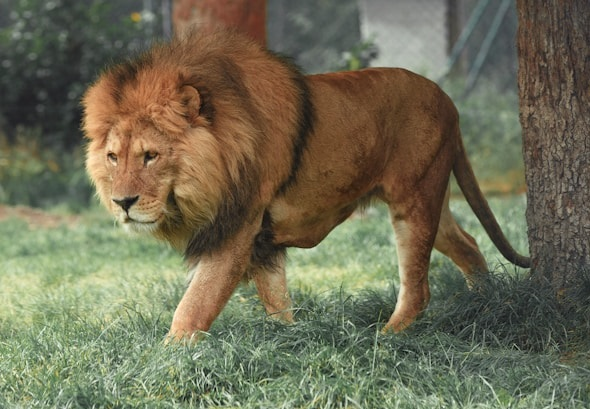

In [11]:
im

In [12]:
# Preprocess the image
def preprocess(img, target_image_size):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

x = preprocess(im, 256)
x = x.to(device)

In [13]:
# Note the results of normalization using map_pixels()
x.min(), x.max()

(tensor(0.1000, device='cuda:0'), tensor(0.9000, device='cuda:0'))

In [14]:
x.shape

torch.Size([1, 3, 256, 256])

In [15]:
# Take an image and project it into an embedding space shared with a decoder
z_logits = enc(x)

In [16]:
# Discretize the image embedding
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

In [17]:
# Given any discretized image embedding, convert it back to image space using the decoder
x_stats = dec(z).float()

In [18]:
x_stats.shape

torch.Size([1, 6, 256, 256])

In [22]:
# Reconstruct the image from the embedding
# Note that unmap_pixels() denormalizes the image
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
im_rec = T.ToPILImage(mode='RGB')(x_rec[0])

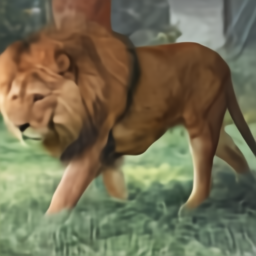

In [23]:
im_rec